<a href="https://colab.research.google.com/github/JuanFelipeSanchez/Data-Scientist/blob/main/Solucion_Reto_SC_63_JuanFelipeSanchez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4.	Incluye las librerías que consideres adecuadas y carga los datos del archivo en una variable llamada “data”.

In [23]:
#Carga inicial de conexiones, funciones y librerías.
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_regression
from tensorflow.keras.models import Sequential
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

drive.mount('/content/gdrive')

#Lectura del archivo csv.
data = pd.read_csv('/content/gdrive/MyDrive/Data Scientist/17. Aprendizaje supervisado/bank_marketing_RETO_DS_AS.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


5.	Obtener la información de dicha base de datos que incluya el número de registros, el total de variables, el tipo de cada variable, la cantidad de datos perdidos de cada variable en caso de que existan.

In [3]:
#Se obtiene información de la base por medio de la función .info().
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        9000 non-null   int64 
 1   job        9000 non-null   object
 2   marital    9000 non-null   object
 3   education  9000 non-null   object
 4   default    9000 non-null   object
 5   balance    9000 non-null   int64 
 6   housing    9000 non-null   object
 7   loan       9000 non-null   object
 8   contact    9000 non-null   object
 9   day        9000 non-null   int64 
 10  month      9000 non-null   object
 11  duration   9000 non-null   int64 
 12  campaign   9000 non-null   int64 
 13  pdays      9000 non-null   int64 
 14  previous   9000 non-null   int64 
 15  poutcome   9000 non-null   object
 16  y          9000 non-null   object
dtypes: int64(7), object(10)
memory usage: 1.2+ MB


6.	Transforma las variables categóricas de manera que puedan ser tratadas numéricamente. Justifica si utilizas LabelEncoder o OneHotEcoder.

Se usa LabelEncoder para aquellas variables que solo contenían dos categorías, como lo son default, housing, loan y Y, ya que al codificar estas columnas entre 0 y 1 se da a entender que cada una de estas variables funciona de una forma binaria. Las demás variables fueron codificadas usando OneHot debido a que, al tener más de dos categorías, los valores asignados podían afectar el funcionamiento del modelo, además que evitaría que el sistema asuma erróneamente que existe un orden entre los datos. Al final la codificación obtenida permite al modelo identificar con mayor claridad el comportamiento de cada variable.

In [25]:
#Se hace la transformación de las variables categóricas en una copia de la base de datos original.
data_transformed = data.copy()

#Se aplica LabelEncoder a las columnas que contienen solamente dos categorías 'default', 'housing', 'loan', 'y'
label_columns = ['default', 'housing', 'loan', 'y']
label_encoders = {}
for col in label_columns:
    le = LabelEncoder()
    data_transformed[col] = le.fit_transform(data_transformed[col])
    label_encoders[col] = le

#Se aplica OneHotEncoder a las otras columnas.
onehot_columns = ['job', 'marital', 'education', 'contact', 'poutcome', 'month']
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
onehot_encoded = onehot_encoder.fit_transform(data_transformed[onehot_columns])
onehot_encoded_df = pd.DataFrame(
    onehot_encoded,
    columns=onehot_encoder.get_feature_names_out(onehot_columns),
    index=data_transformed.index
)

#Se eliminan las columnas originales y se agregan las transformadas.
data_transformed.drop(columns=onehot_columns, inplace=True)
data_transformed = pd.concat([data_transformed, onehot_encoded_df], axis=1)

data_transformed.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,31,0,2666,0,0,10,318,2,97,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,29,0,1584,0,0,6,245,1,-1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,41,0,2152,1,0,17,369,1,-1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,50,0,84,1,0,17,18,8,-1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40,0,0,0,0,28,496,2,182,11,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


7.	Transforma las variables numéricas en los casos que se tenga algún tipo de sesgo.

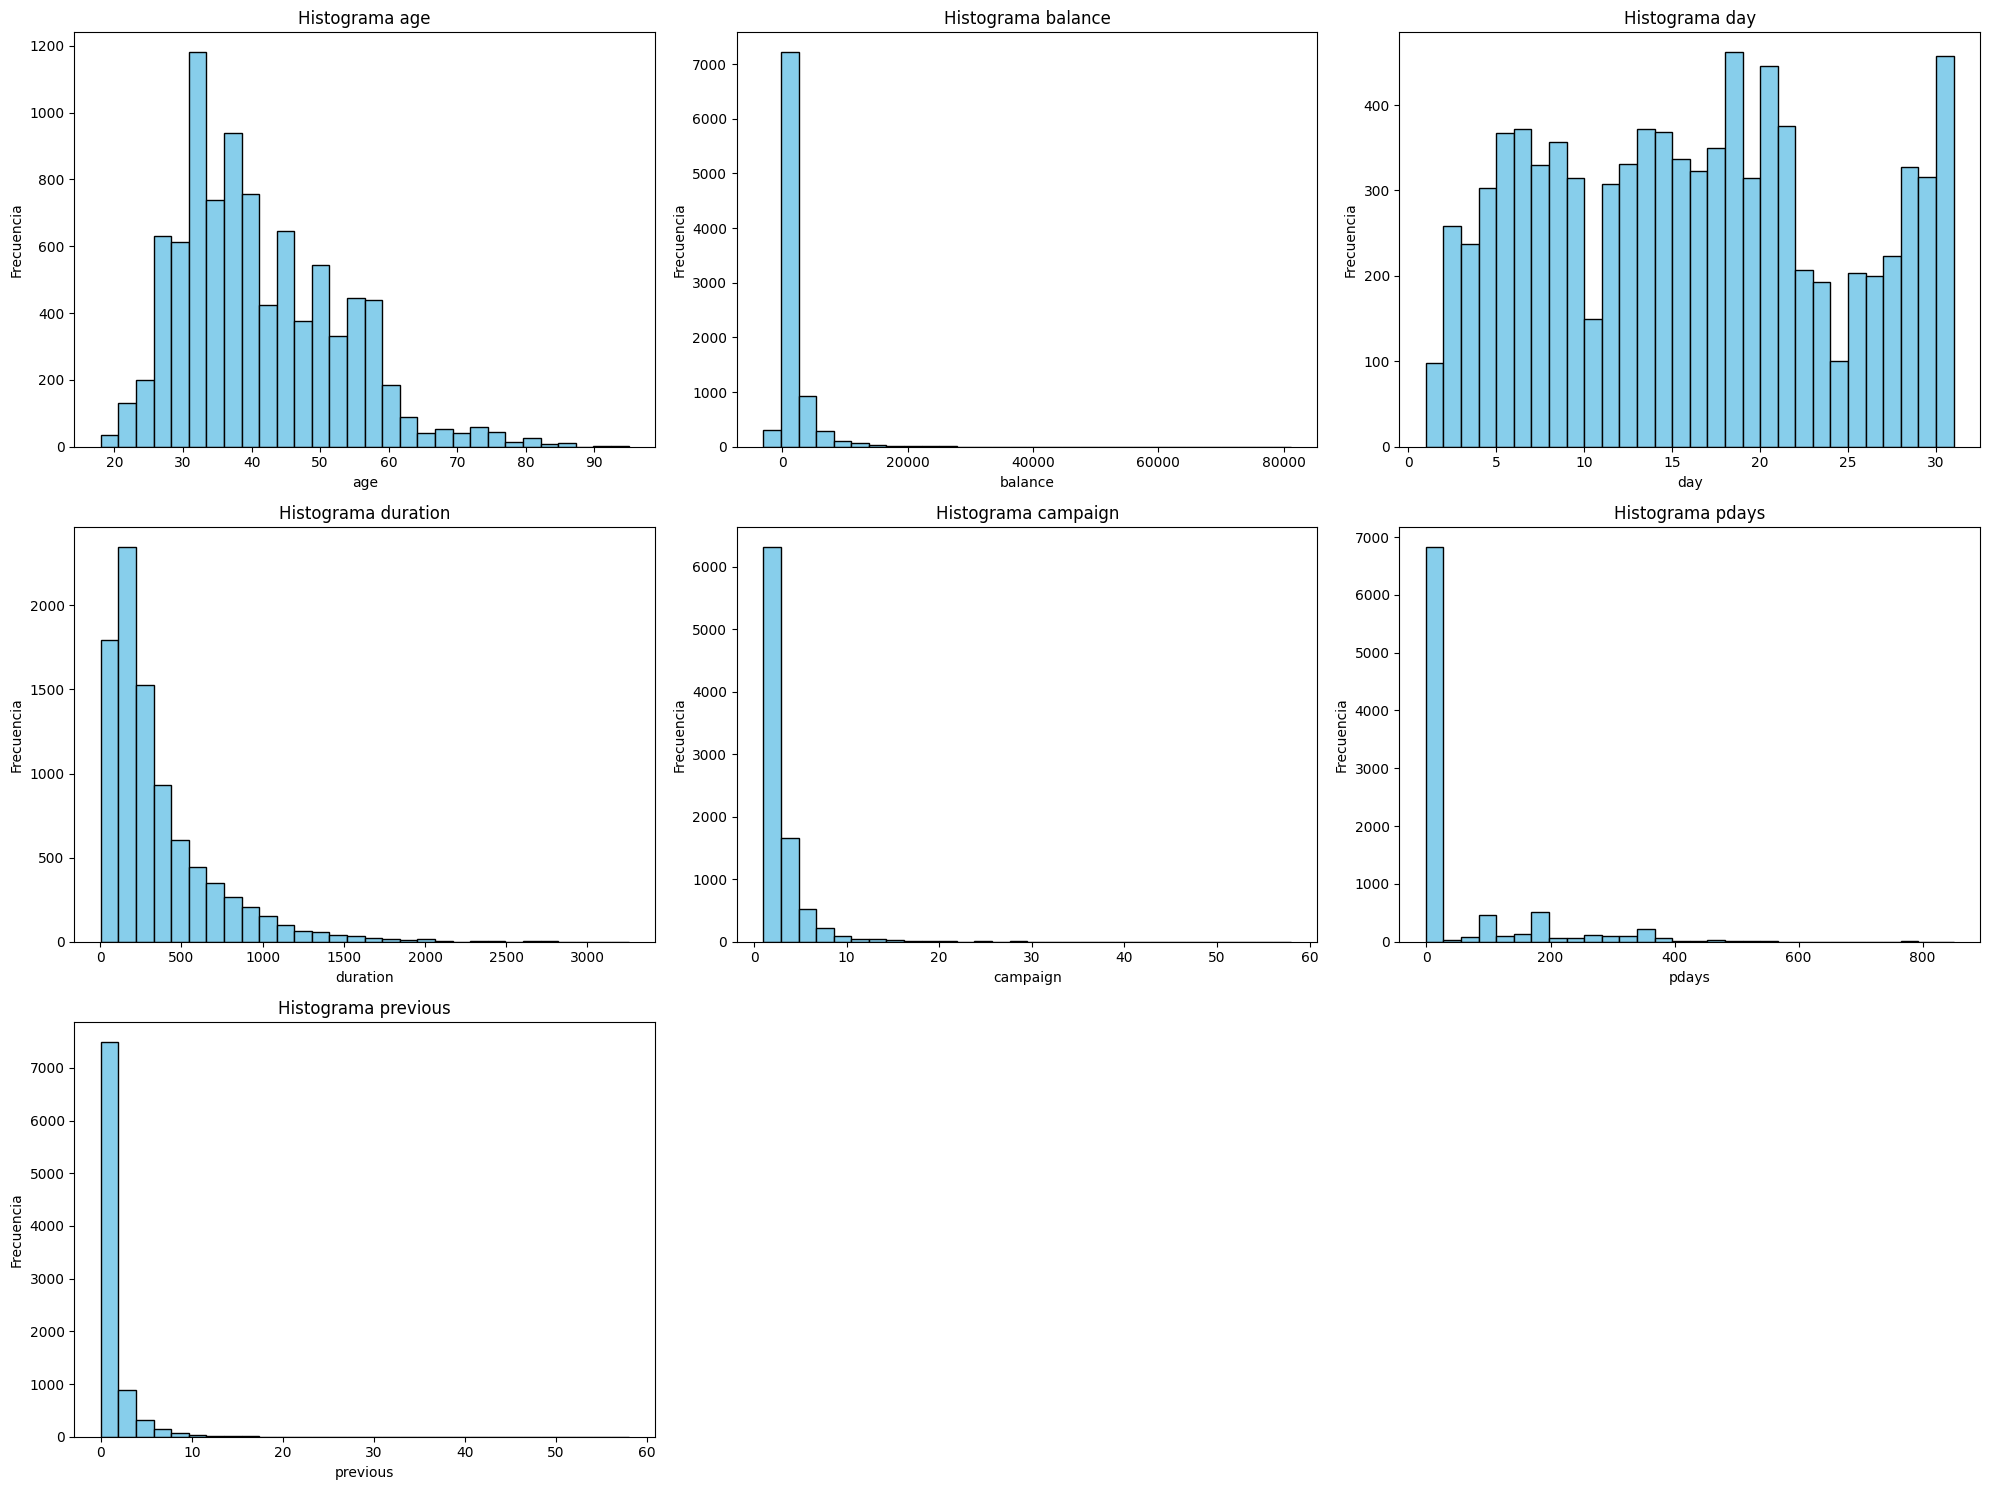

In [5]:
#Las variables a analizar en cuanto al sesgo son las siguientes.
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Crear un histograma por cada columna.
plt.figure(figsize=(20, 15))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    plt.hist(data_transformed[column], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histograma {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [6]:
#Según lo visto previamente, age y days se procesarán por medio de la estandarización/normalización debido a que el sesgo que presentan no es tan extremo.
#Las variables balance, duration,	campaign,	pdays	y previous al tener un sesgo más pronunciado serán procesadas de forma logarítmica.

#Se normaliza la variable 'day'.
scaler_day = MinMaxScaler()
data_transformed['day'] = scaler_day.fit_transform(data_transformed[['day']])

#Se estandariza la variable 'age'.
scaler_age = StandardScaler()
data_transformed['age'] = scaler_age.fit_transform(data_transformed[['age']])

#Se usa la transformación logarítmica en las variables 'balance', 'duration', 'campaign', 'pdays', 'previous'
log_columns = ['balance', 'duration', 'campaign', 'pdays', 'previous']
for col in log_columns:
    data_transformed[col] = np.log(data_transformed[col].clip(lower=0) + 1)

data_transformed.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,-0.865132,0,7.888710,0,0,0.300000,5.765191,1.098612,4.584967,1.945910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.036605,0,7.368340,0,0,0.166667,5.505332,0.693147,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.007764,0,7.674617,1,0,0.533333,5.913503,0.693147,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.763867,0,4.442651,1,0,0.533333,2.944439,2.197225,0.000000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.093501,0,0.000000,0,0,0.900000,6.208590,1.098612,5.209486,2.484907,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


8.	Considera la variable “y” como la variable de salida y el resto de las variables como las variables de entrada.
9.	Particiona los datos en los conjuntos de entrenamiento, validación y prueba en 60%, 20% y 20%, respectivamente.

In [7]:
#Se divide la base de datos en variables de entrada y de salida.
X = data_transformed.drop(columns=['y'])
Y = data_transformed['y']

X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, train_size=.60)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, train_size=.50)

10.	Aplica el modelo Regresión Logística en el conjunto de entrenamiento. Valida el modelo con las predicciones del conjunto de validación y su matriz de confusión. Ajusta los parámetros del modelo hasta obtener tu mejor resultado.

In [8]:
#Se crea el modelo de regresión logística.
model = LogisticRegression(max_iter=1000, random_state=42)

#Se entrena el modelo con el conjunto de entrenamiento previamente seleccionado.
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [11]:
#Se generan las predicciones.
Y_val_pred = model.predict(X_val)

#Se crea la matriz de confusión con los datos obtenidos.
conf_matrix = confusion_matrix(Y_val, Y_val_pred)
print("Matriz de confusión:")
print(conf_matrix)

#Se imprime un breve reporte de clasificación en cuanto a precisión, recall y F1-score.
print("Informe de clasificación del modelo de regresión logística")
print(classification_report(Y_val, Y_val_pred))

Matriz de confusión:
[[906 142]
 [180 572]]
Informe de clasificación del modelo de regresión logística
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1048
           1       0.80      0.76      0.78       752

    accuracy                           0.82      1800
   macro avg       0.82      0.81      0.81      1800
weighted avg       0.82      0.82      0.82      1800



In [12]:
#Se define el rango de hiperparámetros para ajustar el modelo de la manera más optima.
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

#Se configura la malla de hiperparámetros.
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                           param_grid,
                           scoring='accuracy',
                           cv=5)

#Se ajusta el modelo a los datos de entrenamiento con lo obtenido en la malla de hiperparámetros.
grid_search.fit(X_train, Y_train)

#Se define el mejor modelo y sus respetivos parámetros.
best_model = grid_search.best_estimator_
print("Mejores parámetros:")
print(grid_search.best_params_)

Mejores parámetros:
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


In [13]:
#Se generan nuevamente las predicciones con el modelo optimizado.
Y_val_pred_best = best_model.predict(X_val)

#Se recrea la matriz de confusión.
conf_matrix_best = confusion_matrix(Y_val, Y_val_pred_best)
print("Matriz de confusión del mejor modelo:")
print(conf_matrix_best)

#Se genera nuevamente el reporte de clasificación.
print("Informe de clasificación del modelo de regresión logística previamente optimizado")
print(classification_report(Y_val, Y_val_pred_best))

Matriz de confusión del mejor modelo:
[[904 144]
 [176 576]]
Informe de clasificación del modelo de regresión logística previamente optimizado
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1048
           1       0.80      0.77      0.78       752

    accuracy                           0.82      1800
   macro avg       0.82      0.81      0.82      1800
weighted avg       0.82      0.82      0.82      1800



11.	Aplica el modelo Red Neuronal en el conjunto de entrenamiento. Valida el modelo con las predicciones del conjunto de validación y su matriz de confusión. Ajusta los parámetros del modelo hasta obtener tu mejor modelo, entre ellos el número de neuronas y capas ocultas.

In [17]:
#Se crea el modelo de red neuronal.
modelo_NNR = MLPClassifier(hidden_layer_sizes=(10, 4), max_iter=5000, random_state=42)

#Se entrena el modelo.
modelo_NNR.fit(X_train, Y_train)

MLPClassifier(hidden_layer_sizes=(10, 4), max_iter=5000, random_state=42)

In [18]:
#Se realizan las predicciones con el conjunto de validación.
Y_val_pred = modelo_NNR.predict(X_val)

#Se crea la matriz de confusión.
conf_matrix = confusion_matrix(Y_val, Y_val_pred)
print("Matriz de confusión:")
print(conf_matrix)

#Se imprime el reporte de clasificación.
print("Informe de clasificación del modelo de redes neuronales")
print(classification_report(Y_val, Y_val_pred))

Matriz de confusión:
[[881 167]
 [127 625]]
Informe de clasificación del modelo de redes neuronales
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1048
           1       0.79      0.83      0.81       752

    accuracy                           0.84      1800
   macro avg       0.83      0.84      0.83      1800
weighted avg       0.84      0.84      0.84      1800



In [19]:
#Se realiza el ajuste de hiperparámetros.
modelo_NNR = MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', solver='adam', max_iter=5000, alpha=0.001, learning_rate_init=0.01, random_state=42)

#Se entrena nuevamente el modelo.
modelo_NNR.fit(X_train, Y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(32, 16), learning_rate_init=0.01,
              max_iter=5000, random_state=42)

In [20]:
#Se realizan nuevamente las predicciones del conjunto de validación con el modelo ajustado.
Y_val_pred_best = modelo_NNR.predict(X_val)

#Se recrea la matriz de confusión
conf_matrix_best = confusion_matrix(Y_val, Y_val_pred_best)
print("Matriz de confusión modelo optimizado")
print(conf_matrix_best)

#Se imprime nuevamente el reporte de clasificación.
print("Informe de clasificación del modelo de redes neuronales optimizado previamente")
print(classification_report(Y_val, Y_val_pred_best))

Matriz de confusión modelo optimizado
[[847 201]
 [161 591]]
Informe de clasificación del modelo de redes neuronales optimizado previamente
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1048
           1       0.75      0.79      0.77       752

    accuracy                           0.80      1800
   macro avg       0.79      0.80      0.79      1800
weighted avg       0.80      0.80      0.80      1800



12.	Selecciona el mejor modelo encontrado en los incisos anteriores y utiliza el conjunto de prueba para obtener el desempeño final del modelo y su matriz de confusión.

In [22]:
#Al ser un problema de clasificación y no de regresión, los errores cuadráticos, porcentuales y coeficientes de correlación no son efectivos.
#Algunas métricas que si se adaptan a este problema son las siguientes:

#Exactitud (Accuracy): Proporción de predicciones correctas.
#Precisión (Precision): Proporción de verdaderos positivos sobre los positivos predichos.
#Sensibilidad o Recall: Proporción de verdaderos positivos sobre los positivos reales.
#F1-Score: Media armónica de precisión y sensibilidad.
#AUC-ROC: Área bajo la curva ROC, que mide la capacidad del modelo para diferenciar entre clases.

#Evaluación del modelo de Regresión Logística.
Y_val_pred_log = model.predict(X_val)
print("Reporte de clasificación para Regresión Logística")
print(classification_report(Y_val, Y_val_pred_log))
roc_auc_log = roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])
print(f"AUC-ROC - Regresión Logística: {roc_auc_log}")

#Evaluación del modelo de Redes Neuronales.
Y_val_pred_nn = modelo_NNR.predict(X_val)
print("\nReporte de clasificación para Red Neuronal")
print(classification_report(Y_val, Y_val_pred_nn))
roc_auc_nn = roc_auc_score(Y_val, modelo_NNR.predict_proba(X_val)[:, 1])
print(f"AUC-ROC - Red Neuronal: {roc_auc_nn}")

Reporte de clasificación para Regresión Logística
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1048
           1       0.80      0.76      0.78       752

    accuracy                           0.82      1800
   macro avg       0.82      0.81      0.81      1800
weighted avg       0.82      0.82      0.82      1800

AUC-ROC - Regresión Logística: 0.9000109123761573

Reporte de clasificación para Red Neuronal
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1048
           1       0.75      0.79      0.77       752

    accuracy                           0.80      1800
   macro avg       0.79      0.80      0.79      1800
weighted avg       0.80      0.80      0.80      1800

AUC-ROC - Red Neuronal: 0.8730306967679065


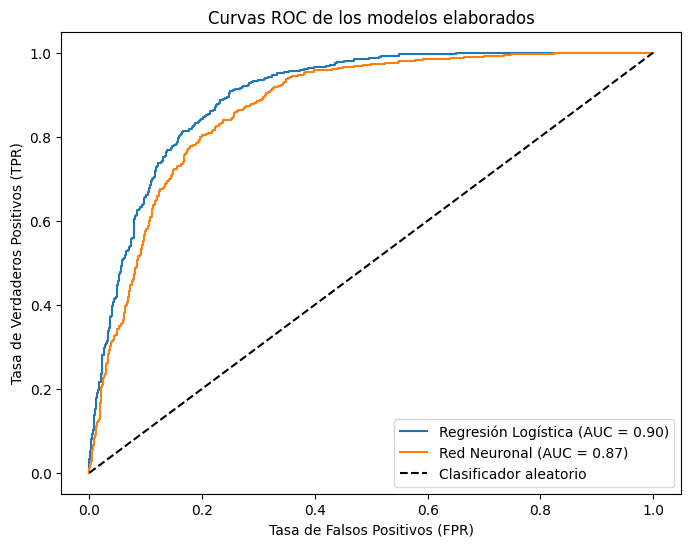

In [24]:
#Se grafica la Curva ROC de ambos modelos para tener una mejor idea sobre el rendimiento general. Este recurso fue consultado e investigado externamente a lo visto en el módulo.

#Para Regresión Logística.
fpr_log, tpr_log, _ = roc_curve(Y_val, model.predict_proba(X_val)[:, 1])
#Para Red Neuronal.
fpr_nn, tpr_nn, _ = roc_curve(Y_val, modelo_NNR.predict_proba(X_val)[:, 1])

# Graficar ambas curvas
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Regresión Logística (AUC = {roc_auc_log:.2f})")
plt.plot(fpr_nn, tpr_nn, label=f"Red Neuronal (AUC = {roc_auc_nn:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Clasificador aleatorio")
plt.title("Curvas ROC de los modelos elaborados")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend()
plt.show()

Según las métricas y las curvas ROC se puede concluir lo siguiente:

En cuanto al Accuracy, ambos modelos tienen un rendimiento muy similar, pero la regresión logística es superior por poco.

El modelo de regresión logística tiene un F1-Score más alto para ambas clases, lo que demuestra un mejor equilibrio entre la precisión y el recall.

Si un modelo tiene un AUC más alto, es mejor para diferenciar entre las clases. Esta gráfica permite identificar el modelo que mantiene mejor balance entre la Tasa de Verdaderos Positivos y la Tasa de Falsos Positivos. Según este recurso, el mejor modelo es el de regresión logística.

Lo anterior nos demuestra que el modelo de regresión logística es mejor, ya que distingue mejor las clases sin comprometerlas.


In [26]:
#Se realizan las predicciones con el conjunto de prueba.
Y_test_pred = model.predict(X_test)

#Se generan las probabilidades para calcular AUC-ROC.
Y_test_prob = model.predict_proba(X_test)[:, 1]

#Elaboración de la matriz de confusión.
matriz_confusion = confusion_matrix(Y_test, Y_test_pred)
print("Matriz de confusión")
print(matriz_confusion)

#Se genera el reporte de clasificación del modelo obtenido.
reporte = classification_report(Y_test, Y_test_pred)
print("\nReporte de Clasificación del modelo de Regresión logística")
print(reporte)

#Cálculo del AUC-ROC (Area Under the Curve - Receiver Operating Characteristic Curve).
auc_roc_test = roc_auc_score(Y_test, Y_test_prob)
print(f"\nAUC-ROC en el conjunto de prueba: {auc_roc_test}")

Matriz de confusión
[[894 131]
 [171 604]]

Reporte de Clasificación del modelo de Regresión logística
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1025
           1       0.82      0.78      0.80       775

    accuracy                           0.83      1800
   macro avg       0.83      0.83      0.83      1800
weighted avg       0.83      0.83      0.83      1800


AUC-ROC en el conjunto de prueba: 0.912402832415421


13.	Incluye tus conclusiones del problema, en particular, ¿qué puedes decir acerca del uso de técnicas de inteligencia artificial en problemas de mercadotecnia?

La inteligencia artificial ciertamente ha demostrado ser una gran herramienta en cualquier entorno, sector económico o empresa, su funcionalidad es tan simple que cualquier persona con acceso al internet puede utilizarla para casi cualquier objetivo. Cuando una algo tan ilimitado como esto se mezcla con la estadística, la analítica y el pensamiento crítico y lógico, es fácil llegar a cualquier meta, cosa que facilita y reduce la cantidad de recursos necesarios para obtener algo. En el caso de la mercadotecnia es lo mismo, la IA facilita la búsqueda de información necesaria para realizar estudios o análisis en el mercado, brinda todos los mecanismos posibles para procesar eso y convertirlo en ideas tangibles que permiten generar conclusiones que más adelante se van a transformar en estrategias de negocio, que es exactamente lo que se quiere lograr. La IA es una herramienta que cuando se sabe aprovechar, permite hacer grandes cosas, aplicar correctamente las técnicas estadísticas y matemáticas con este gran recurso permite tanto a analistas como directivos obtener resultados de manera fácil y extremadamente rápida. La IA llegó para quedarse y evolucionar, cosa que nosotros debemos hacer en conjunto al adaptar nuestros métodos ya conocidos.